Average test MAE loss: 0.27487978498444304


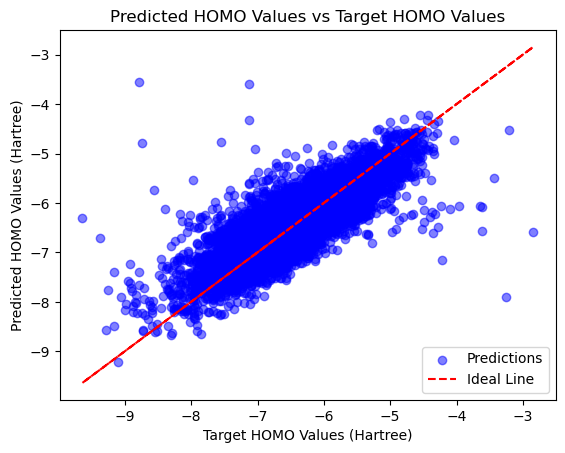

<Figure size 640x480 with 0 Axes>

In [1]:
import os
import torch
import torch.nn as nn
import numpy as np
from Dataloader import DataLoaderQM9
from Model import PaiNN
from Training import Trainer
from Model import saveModel, mse, mae, test
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def test(model, test_set):
    model.eval()
    device = next(model.parameters()).device

    test_loss = 0.0
    
    with torch.no_grad():
        for batch_num, batch in enumerate(test_set):
            targets = batch["targets"][:, 2].to(device).unsqueeze(dim=-1)
            outputs = model(batch)
            loss = mae(outputs, targets)
            test_loss += loss.item()
    avg_test_loss = test_loss / (batch_num + 1)
    print(f"Average test MAE loss: {avg_test_loss}")

# Load the pre-trained model with map_location
best_model = PaiNN(r_cut=5, device=device).to(device)
best_model.load_state_dict(torch.load("./HOMO_best_PaiNNModel.pth", map_location='cpu'))
test(best_model, DataLoaderQM9(r_cut=5, batch_size=100).get_test())

# Plotting the predicted outputs vs target values
def plot_predictions(model, test_set):
    model.eval()
    device = next(model.parameters()).device

    predictions = []
    targets = []

    with torch.no_grad():
        for batch_num, batch in enumerate(test_set):
            target_batch = batch["targets"][:, 2].cpu().numpy()
            output_batch = model(batch).cpu().numpy()

            targets.extend(target_batch)
            predictions.extend(output_batch)

    plt.scatter(targets, predictions, alpha=0.5, color='blue', label='Predictions')
    plt.plot(targets, targets, color='red', linestyle='--', label='Ideal Line')  # Ideal line
    plt.xlabel("Target HOMO Values (Hartree)")
    plt.ylabel("Predicted HOMO Values (Hartree)")
    plt.title("Predicted HOMO Values vs Target HOMO Values")
    plt.legend()
    plt.show()

# Plotting and saving the plot
plot_predictions(best_model, DataLoaderQM9(r_cut=5, batch_size=100).get_test())
plt.savefig("predicted_vs_target_plot_homo.png")
